In [1]:
%matplotlib inline

In [15]:
import os
import numpy as np
import nibabel as nb
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import widgets, Layout
from IPython.display import display
from nipype.interfaces.fsl import BET, MeanImage, ApplyMask, SwapDimensions, MELODIC, MCFLIRT
from nipype.interfaces.afni import SkullStrip, Automask, MaskTool
from nipype.algorithms.rapidart import ArtifactDetect
import seaborn as sns
from nipype.interfaces.ants import N4BiasFieldCorrection, Registration, ApplyTransforms
from pca_utils import pca_denoising
from functions import nilearn_denoise, motion_regressors
from nilearn.input_data import NiftiMasker
from nilearn.image import high_variance_confounds

In [3]:
in_file = '/home/julia/projects/fast_rsfmri/rita_1/converted/RFGVS033/RFGVS033_8/RFGVS033_8.nii.gz'
out_dir = '/home/julia/projects/fast_rsfmri/rita_1/processed/8/'

In [4]:
data = nb.load(in_file).get_data()
func_affine = nb.load(in_file).affine
func_header = nb.load(in_file).header

### Fix dimensions

In [5]:
# make 4D and save
func_data = data[:,:,np.newaxis,:]
nb.save(nb.Nifti1Image(func_data, func_affine, func_header), out_dir+"func.nii.gz")

### Remove initial volumes

In [6]:
vol_to_remove = 200

In [7]:
mean_ts_before = np.average(np.average(np.average(func_data, axis=0), axis=0),axis=0)
mean_ts_after = np.average(np.average(np.average(func_data[:,:,:,vol_to_remove:], axis=0), axis=0),axis=0)

In [8]:
func_steady = nb.Nifti1Image(func_data[:,:,:,vol_to_remove:], func_affine, func_header)
nb.save(func_steady, out_dir+'func_steady.nii.gz')

In [9]:
upper=np.mean(mean_ts_after)+3*np.std(mean_ts_after)
lower=np.mean(mean_ts_after)-3*np.std(mean_ts_after)
outliers = np.hstack((np.where(mean_ts_after>upper),np.where(mean_ts_after<lower))).flatten()
outlier_regressor = np.zeros((mean_ts_after.shape[0],outliers.shape[0]))
for o in range(outliers.shape[0]):
    outlier_regressor[outliers[o], o]=1

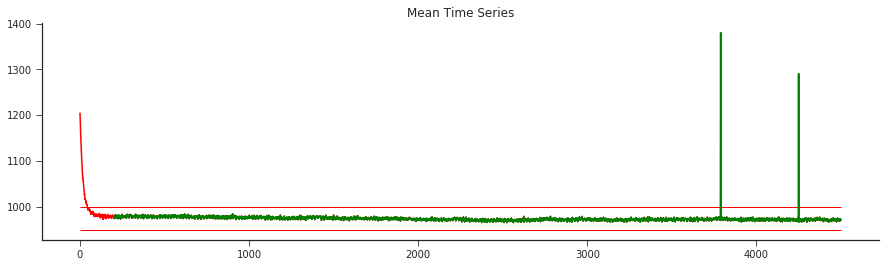

In [10]:
sns.set_style("ticks")
fig=plt.figure(figsize=(15,4))
plt.plot(mean_ts_before, color='red')
plt.plot(np.linspace(vol_to_remove, func_data.shape[3]-1, func_data.shape[3]-vol_to_remove), mean_ts_after, color='g')
plt.hlines((upper,lower), xmin=0, xmax=len(mean_ts_before), linewidth=1, color='red')
plt.title("Mean Time Series")
sns.despine()

### Bias field correction and masking 

In [11]:
mean = MeanImage(in_file=out_dir+'func_steady.nii.gz', out_file=out_dir+'func_mean.nii.gz')
mean.run()

In [12]:
n4_func = N4BiasFieldCorrection(dimension=2,input_image=out_dir+'func_mean.nii.gz', 
                                   n_iterations=[150,100,50,30], convergence_threshold=1e-11,
                                   bspline_fitting_distance = 10, bspline_order = 4,
                                   shrink_factor = 2,
                                   output_image= out_dir + 'func_mean_corr.nii.gz')
n4_func.run()

In [14]:
func_mask = Automask(in_file=out_dir+'func_mean_corr.nii.gz', out_file=out_dir+'func_mask.nii.gz',
                     brain_file=out_dir+'func_mean_masked.nii.gz', 
                     args='-peels 3', dilate=1, outputtype='NIFTI_GZ')
func_mask.run()

181217-10:53:02,744 interface INFO:
	 stderr 2018-12-17T10:53:02.744193:++ 3dAutomask: AFNI version=AFNI_18.3.03 (Oct 19 2018) [64-bit]
181217-10:53:02,746 interface INFO:
	 stderr 2018-12-17T10:53:02.746030:++ Authored by: Emperor Zhark
181217-10:53:02,747 interface INFO:
	 stderr 2018-12-17T10:53:02.746030:*+ WARNING:   If you are performing spatial transformations on an oblique dset, 
181217-10:53:02,747 interface INFO:
	 stderr 2018-12-17T10:53:02.746030:  such as /home/julia/projects/fast_rsfmri/rita_1/processed/8/func_mean_corr.nii.gz,
181217-10:53:02,748 interface INFO:
	 stderr 2018-12-17T10:53:02.746030:  or viewing/combining it with volumes of differing obliquity,
181217-10:53:02,749 interface INFO:
	 stderr 2018-12-17T10:53:02.746030:  you should consider running: 
181217-10:53:02,750 interface INFO:
	 stderr 2018-12-17T10:53:02.746030:     3dWarp -deoblique 
181217-10:53:02,751 interface INFO:
	 stderr 2018-12-17T10:53:02.746030:  on this and  other oblique datasets in the 

### Nuissance regression

In [41]:
nb.save(nb.Nifti1Image(nb.load(out_dir+"ventricle_mask.nii.gz").get_data(), func_affine, func_header), out_dir+"ventricle_mask.nii.gz")

ventricle_regressor = high_variance_confounds(out_dir+"func_steady.nii.gz", 
                                          mask_img=out_dir+"ventricle_mask.nii.gz", 
                                          detrend=True)

In [129]:
nb.save(nb.Nifti1Image(nb.load(out_dir+"func_mask.nii.gz").get_data()[:,:,np.newaxis], func_affine, func_header), 
        out_dir+"func_mask.nii.gz")

In [133]:
confounds=np.hstack((outlier_regressor, ventricle_regressor))

In [425]:
brain_masker = NiftiMasker(mask_img=out_dir+"func_mask.nii.gz", 
                           standardize=True, detrend=True, 
                           t_r=0.05, smoothing_fwhm=0.5, high_pass=0.01, low_pass=2)
filtered_data = brain_masker.fit_transform(out_dir+'func_steady.nii.gz', confounds=confounds)
filtered_img = brain_masker.inverse_transform(filtered_data)
filtered_img.to_filename(out_dir+'func_filtered_band.nii.gz')

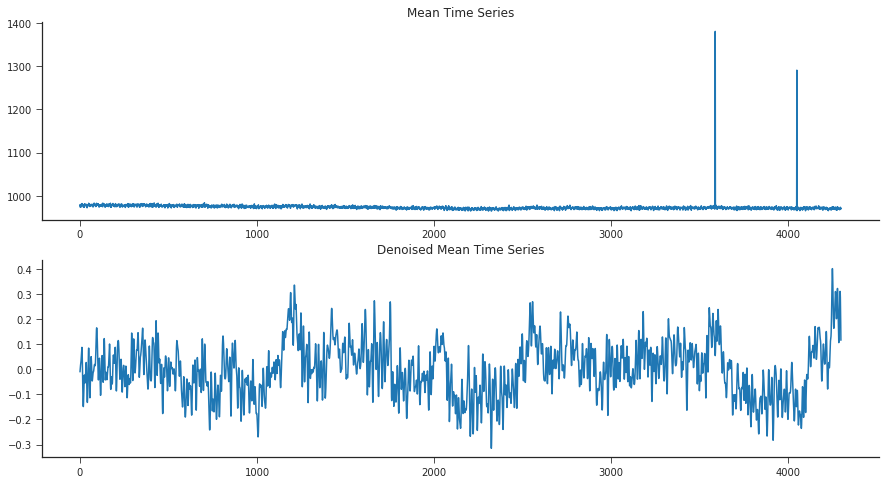

In [426]:
sns.set_style("ticks")
fig=plt.figure(figsize=(15,8))
fig.add_subplot(2,1,1)
plt.plot(mean_ts_after)
plt.title("Mean Time Series")
fig.add_subplot(2,1,2)
plt.plot(np.average(filtered_data, axis=1))
plt.title("Denoised Mean Time Series")
sns.despine()

### Connectivity

In [437]:
seed = out_dir+'right_V1_superficial.nii.gz'
func = out_dir+'func_filtered_band.nii.gz'
conn = out_dir+'conn_band_right_V1_superficial.nii.gz'

In [438]:
seed_masker = NiftiMasker(mask_img=seed,smoothing_fwhm=0.2)
seed_ts = seed_masker.fit_transform(func)
avg_seed_ts = np.average(seed_ts, axis=1)

In [439]:
seed_based_correlations = np.dot(filtered_data.T, avg_seed_ts) / avg_seed_ts.shape[0]
seed_based_correlations_fisher_z = np.arctanh(seed_based_correlations)

In [440]:
full_img_masker=brain_masker = NiftiMasker(mask_img=out_dir+"func_mask.nii.gz")
full_img_masker=brain_masker.fit(func)
seed_based_correlation_img = full_img_masker.inverse_transform(seed_based_correlations_fisher_z.T)
seed_based_correlation_img.to_filename(conn)

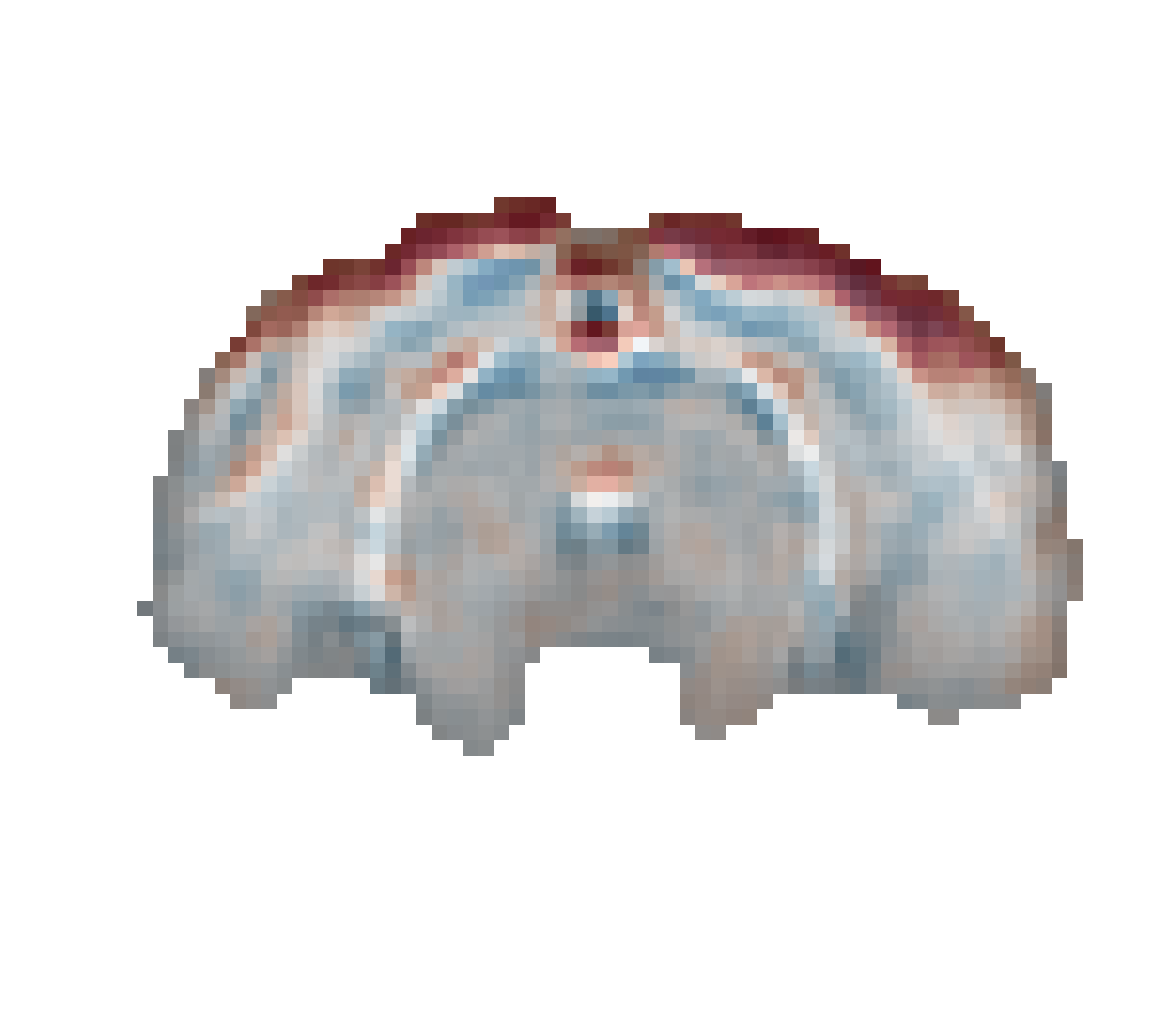

In [441]:
data=nb.load(conn).get_data().squeeze()
vmax=max(abs(data.min()), abs(data.max()))

bg=nb.load(out_dir+'func_mean_masked.nii.gz').get_data().squeeze()
bg[bg==0]=np.nan

#thresh=0.04
#data[np.logical_and((data >= -thresh),(data <= thresh))]=np.nan
data[data==0]=np.nan

fig=plt.figure(figsize=(20,20))
plt.imshow(bg.T, cmap='Greys_r');
plt.imshow(data.T, cmap='RdBu_r', alpha=0.5, vmin=-vmax, vmax=vmax);
plt.axis('off');

### ICA

In [180]:
nb.save(nb.Nifti1Image(nb.load(out_dir+"func_mean_masked.nii.gz").get_data(), 
                       func_affine, func_header), out_dir+"func_mean_masked.nii.gz")

In [181]:
ica= MELODIC(in_files=out_dir+'func_filtered.nii.gz',  mask=out_dir+'func_mask.nii.gz', 
             bg_image=out_dir+'func_mean_masked.nii.gz', out_dir=out_dir+'ica/',
             no_bet=True, bg_threshold=1, tr_sec=0.05, report=True)
ica.run()

In [46]:
! fsl_regfilt -i /home/julia/projects/lc/JH_LC_rsfMRI_05_analysis/func_filtered.nii.gz -d /home/julia/projects/lc/JH_LC_rsfMRI_05_analysis/ica/melodic_mix -f "1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,38,39,40" -o /home/julia/projects/lc/JH_LC_rsfMRI_05_analysis/func_denoised.nii.gz